# **Project 2**  
*AEEM 2058*  
*Date*:12/3/2025  
Hayden Mays, Logan Mueller, Evan Wills  
___

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

## **A**   
___

<div class='alert alert-block alert-warning'>
<b>Warning: </b>If the c value is to high the target is unreachable
</div>

### Initial Forward Process

Initial Velocity: 100.000 m/s
Initial Angle: 45.000°

   Time   |   X Velocity  |  Y Velocity  
------------------------------------------
  20.010 s |   18.775 m/s |  -85.692 m/s  

Range: 798.262 m | 0.496 Mile(s)
Finial Z: -558.749 m



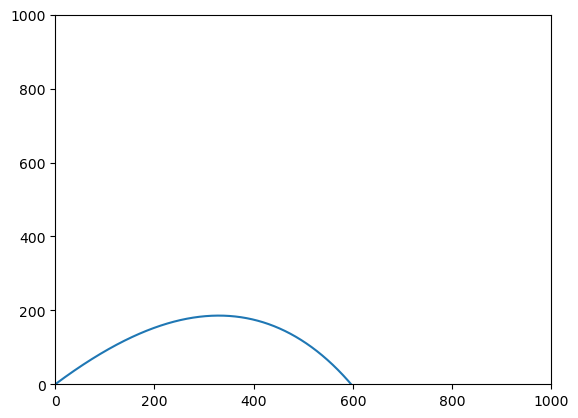

In [2]:
def RK4(y,system:callable,h,t):
    k1=system(t,y)
    k2=system(t+h/2,y+(k1/2)*h)
    k3=system(t+h/2,y+(k2/2)*h)
    k4=system(t+h,y+(k3)*h)  
    
        
        # Update y value using the weighted average of the slopes
    y=y+(1/6)*(k1+2*k2+2*k3+k4)*h
    return y

def Euler(t_0:float,t_f:float,h:float,S_initial:float,dSdt:callable)-> tuple [np.ndarray:'S values',np.ndarray]:
    ''' Runs Euler method
    
    Args:
        t_0: the initial time
        t_f: the finial time
        h: the step length between the initial and finial time
        S_initial: the initial condition
        dSdt: the ODE for S
        
    Returns:
        tuple of 2 arrays
        (t_span,S)
        
    '''
    t_span=np.arange(t_0,t_f+h,h) # creates span
    
    S=np.zeros((len(t_span),4)) # Creates array for outputs
    S[0]=S_initial #Sets intial value
    
    # Runs euler aproximation
    for i in range(len(t_span)-1):
        S[i+1]=S[i]+h*dSdt(t_span[i],S[i])
    
    # Returns t_span and the outputs
    return t_span,S

def system(t,state):
    x,z,v_x,v_z=state
    g=9.8 #m/s^2
    c=1e-3 #m^-1
    dx=v_x
    dz=v_z
    v=np.sqrt(v_x**2+v_z**2)
    dv_x=-c*v_x*v
    dv_z=-g-c*v_z*v
    
    return np.array([dx,dz,dv_x,dv_z])



t_initial=0
t_finial=20
t_step=0.01
N=int((t_finial-t_initial)/t_step)



v0=100 #m/s
theta0=45

y0=np.array([0,0,v0*np.cos(np.deg2rad(theta0)),v0*np.sin(np.deg2rad(theta0))])

t_c,v=Euler(t_initial,t_finial,t_step,y0,system)
v_x=v.T[2]
trapx=(t_step/2)*(v_x[0]+ 2*sum(v_x[1:N-1])+v_x[N-1])

v_z=v.T[3]
trapz=(t_step/2)*(v_z[0]+ 2*sum(v_z[1:N-1])+v_z[N-1])

print(f'Initial Velocity: {v0:0.03f} m/s')
print(f'Initial Angle: {theta0:0.03f}°\n')

print('Time'.center(10)+'|'+'X Velocity'.center(15)+'|'+'Y Velocity'.center(14))
print(''.center(42,'-'))
for t,vx,vz in zip(t_c,v_x,v_z):
    print(f'{t:7.03f} s | {vx:8.03f} m/s | {vz:8.03f} m/s'.center(42),end='\r',flush=True)

print(f'\n\nRange: {trapx:0.03f} m | {trapx/1609:0.03f} Mile(s)')

print(f'Finial Z: {trapz:0.03f} m\n')
plt.plot(v.T[0],v.T[1])
plt.ylim((0,1000))
plt.xlim((0,1000))
plt.show()

### Solving Methods

----------------------------------------------------
Target Range (m): 804.67
----------------------------------------------------
Estimated v0 (m/s): 128.3256199048913
Estimated θ0 (degrees): 38.7484500049768
----------------------------------------------------
Final simulated range (m): 804.6539678383368
Maximum height (m): 214.4220822249467
Flight time (s): 13.129
----------------------------------------------------


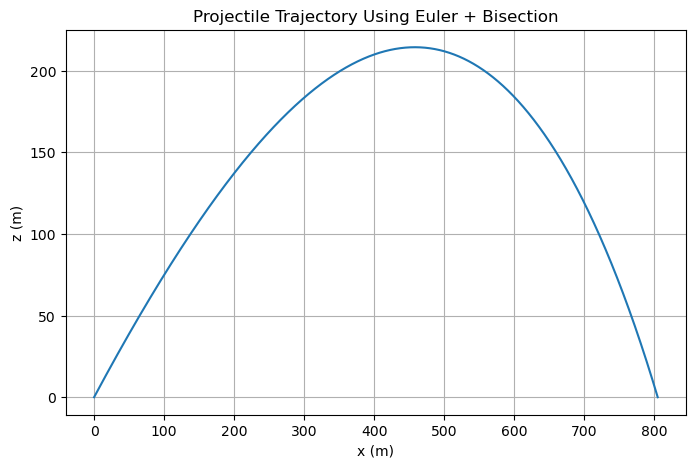

In [3]:
# Part A)
import numpy as np
import matplotlib.pyplot as plt

#Euler's method 
def euler(f, x0, t0, tmax, dt):
    N = int(np.floor((tmax - t0) / dt) + 1)
    t = np.linspace(t0, tmax, N)
    x = np.zeros_like(t, dtype=float)
    x[0] = x0

    for n in range(len(t) - 1):
        x[n + 1] = x[n] + dt * f(t[n], x[n])
    return t, x



# Vector Euler Method 

def euler_vec(F, y0, t0, tmax, dt):
    N = int(np.floor((tmax - t0) / dt) + 1)
    t = np.linspace(t0, tmax, N)
    y = np.zeros((N, len(y0)))
    y[0] = y0

    for n in range(N - 1):
        y[n+1] = y[n] + dt * F(t[n], y[n])

        # Stop when projectile hits ground
        if y[n+1, 1] < 0:
            return t[:n+2], y[:n+2]

    return t, y



# Projectile ODE system with drag

g = 9.81
c = 1e-3  # drag coefficient

def projectile_ode(t, y):
    x, z, vx, vz = y
    v = np.sqrt(vx**2 + vz**2)
    return np.array([
        vx,
        vz,
        -c * vx * v,
        -g - c * vz * v
    ])


# Compute range for given v0 and theta0

def compute_range(v0, theta0_deg):
    theta = np.radians(theta0_deg)
    vx0 = v0 * np.cos(theta)
    vz0 = v0 * np.sin(theta)

    y0 = np.array([0, 0, vx0, vz0])
    t, Y = euler_vec(projectile_ode, y0, 0, 60, 0.001)

    x = Y[:, 0]
    return x[-1]



# Bisection Method

def bisection(func, a, b, tol=1e-3, max_iter=100):
    fa = func(a)
    fb = func(b)

    if fa * fb > 0:
        raise ValueError("Bisection error: f(a) and f(b) must have opposite signs.")

    for _ in range(max_iter):
        m = 0.5 * (a + b)
        fm = func(m)

        if abs(fm) < tol:
            return m

        if fa * fm < 0:
            b = m
            fb = fm
        else:
            a = m
            fa = fm

    return 0.5 * (a + b)



# Set Target Distance

Target_Range_Miles = 0.5
target_range = Target_Range_Miles * 1609.34  # convert to meters
print("----------------------------------------------------")
print("Target Range (m):", target_range)



# Solve for v0 first (holding theta fixed)

fixed_theta = 40  # degrees

def f_v0(v0):
    return compute_range(v0, fixed_theta) - target_range

# Automatically bracket v0
v0_vals = np.linspace(10, 400, 300)
f_vals = [f_v0(v) for v in v0_vals]

v0_a = None
v0_b = None
for i in range(len(v0_vals) - 1):
    if f_vals[i] * f_vals[i+1] < 0:
        v0_a = v0_vals[i]
        v0_b = v0_vals[i+1]
        break

if v0_a is None:
    raise RuntimeError("Cannot bracket v0 — try increasing search range.")

v0_solution = bisection(f_v0, v0_a, v0_b)
print("----------------------------------------------------")
print("Estimated v0 (m/s):", v0_solution)


# Solve for theta using found v0

def f_theta(theta):
    return compute_range(v0_solution, theta) - target_range

# Automatically bracket theta
theta_vals = np.linspace(1, 89, 200)
f_vals = [f_theta(th) for th in theta_vals]

theta_a = None
theta_b = None
for i in range(len(theta_vals) - 1):
    if f_vals[i] * f_vals[i+1] < 0:
        theta_a = theta_vals[i]
        theta_b = theta_vals[i+1]
        break

if theta_a is None:
    raise RuntimeError("Cannot bracket theta — unexpected.")

theta_solution = bisection(f_theta, theta_a, theta_b)
print("Estimated θ0 (degrees):", theta_solution)
print("----------------------------------------------------")



# Final trajectory with solved v0 and theta

theta = np.radians(theta_solution)
vx0 = v0_solution * np.cos(theta)
vz0 = v0_solution * np.sin(theta)

y0 = np.array([0, 0, vx0, vz0])
t, Y = euler_vec(projectile_ode, y0, 0, 60, 0.001)

x = Y[:, 0]
z = Y[:, 1]

print("Final simulated range (m):", x[-1])
print("Maximum height (m):", np.max(z))
print("Flight time (s):", t[-1])
print("----------------------------------------------------")

# Plot the final trajectory

plt.figure(figsize=(8,5))
plt.plot(x, z)
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.title("Projectile Trajectory Using Euler + Bisection")
plt.grid(True)
plt.show()

In [4]:
# Part A) - Alternative Approach
import numpy as np
from scipy.integrate import solve_ivp

# Constants
g = 9.81
c = 1e-3   # drag coefficient (1/m)

def projectile_ode(t, y):
    x, z, vx, vz = y
    v = np.sqrt(vx**2 + vz**2)
    dvx = -c * vx * v
    dvz = -g - c * vz * v
    return np.array([vx, vz, dvx, dvz], dtype=float)

def simulate_range(v0, theta, tmax=200):
    vx0 = v0 * np.cos(theta)
    vz0 = v0 * np.sin(theta)

    y0 = [0, 0, vx0, vz0]

    # Stop when z hits the ground again
    def hit_ground(t, y):
        return y[1]
    hit_ground.terminal = True
    hit_ground.direction = -1

    sol = solve_ivp(projectile_ode, [0, tmax], y0, events=hit_ground, max_step=0.05)

    if sol.status == 1:
        return sol.y_events[0][0][0]   # x-position at z = 0
    else:
        return np.nan


def Bisection_Method(target_x, theta, vmin=5, vmax=500):
    for _ in range(60):
        vmid = 0.5 * (vmin + vmax)
        x_mid = simulate_range(vmid, theta)

        if np.isnan(x_mid):
            vmin = vmid
            continue

        if x_mid < target_x:
            vmin = vmid
        else:
            vmax = vmid

    return 0.5 * (vmin + vmax)



def find_v0_for_range(target_x, theta):
    return Bisection_Method(target_x, theta)


def PartA(target_x, angles=np.linspace(0.2, 1.0, 20)):
    best = None

    for theta in angles:
        v0 = find_v0_for_range(target_x, theta)
        if best is None or v0 < best[1]:
            best = (theta, v0)

    return best


# Initial Guess 0.5 miles ≈ 804.67 m
miles = 0.5
meters = miles * 1609.34

target_range = meters # meters
theta_final, v0_final = PartA(target_range)

print("Best angle (deg):", np.degrees(theta_final))
print("Required v0 (m/s):", v0_final)

Best angle (deg): 40.40860239343701
Required v0 (m/s): 128.3661140525724


----------- VALIDATION RESULTS -----------
Target Range:            804.67 m
-------------------------------------------
θ = 38.7° → Range = 804.61 m  → Error = -0.06 m
θ = 40.4° → Range = 804.38 m → Error = -0.29 m
-------------------------------------------


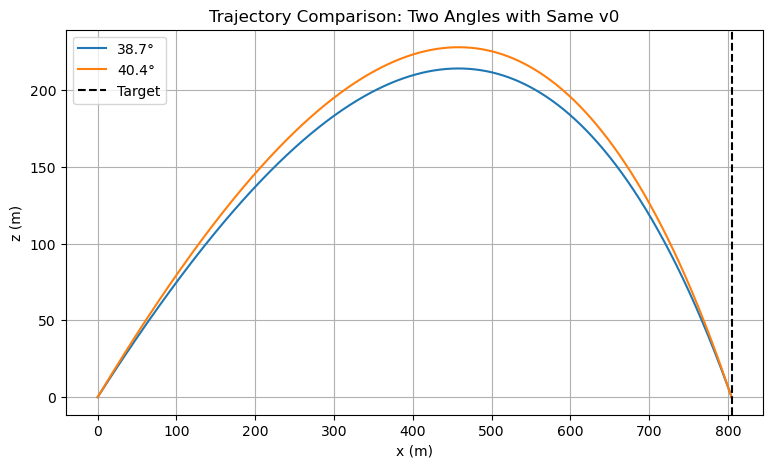

----------- CONCLUSION -----------
Both angles provide valid solutions for the given v0.


In [5]:
# Validation
import numpy as np
import matplotlib.pyplot as plt

# Known solutions:
v0_test = 128.32
theta_low = 38.7   # from your code
theta_high = 40.4  # from your alternative code
Target_Range_Miles = 0.5
target_range = Target_Range_Miles * 1609.34  # convert to meters


# Validate each angle by computing their true range

range_low = compute_range(v0_test, theta_low)
range_high = compute_range(v0_test, theta_high)

print("----------- VALIDATION RESULTS -----------")
print(f"Target Range:            {target_range:.2f} m")
print("-------------------------------------------")
print(f"θ = {theta_low}° → Range = {range_low:.2f} m  → Error = {range_low - target_range:.2f} m")
print(f"θ = {theta_high}° → Range = {range_high:.2f} m → Error = {range_high - target_range:.2f} m")
print("-------------------------------------------")


# Plot both trajectories on the same figure for visual verification

def compute_trajectory(v0, theta_deg):
    theta = np.radians(theta_deg)
    vx0 = v0 * np.cos(theta)
    vz0 = v0 * np.sin(theta)
    y0 = np.array([0, 0, vx0, vz0])
    return euler_vec(projectile_ode, y0, 0, 60, 0.001)


# Compute both trajectories
t1, Y1 = compute_trajectory(v0_test, theta_low)
t2, Y2 = compute_trajectory(v0_test, theta_high)

x1, z1 = Y1[:,0], Y1[:,1]
x2, z2 = Y2[:,0], Y2[:,1]

plt.figure(figsize=(9,5))
plt.plot(x1, z1, label=f"{theta_low}°")
plt.plot(x2, z2, label=f"{theta_high}°")

plt.axvline(target_range, color='k', linestyle='--', label="Target")
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.title("Trajectory Comparison: Two Angles with Same v0")
plt.legend()
plt.grid(True)
plt.show()

# Determine if both angles correctly hit the target

def hits_target(calc_range, target, tol=3.0):
    return abs(calc_range - target) <= tol

print("----------- CONCLUSION -----------")
if hits_target(range_low, target_range) and hits_target(range_high, target_range):
    print("Both angles provide valid solutions for the given v0.")
elif hits_target(range_low, target_range):
    print("Only the lower angle is valid.")
elif hits_target(range_high, target_range):
    print("Only the higher angle is valid.")
else:
    print("Neither angle reaches the target within the tolerance.")

###  
---

Best Tested Values:
Angle:40.00
Velocity:128.19
Initail:
X:  0.00 m | Z:  0.00 m | V:128.19 m/s

Finial:
X:804.53 m | Z: -0.57 m | V: 68.72 m/s


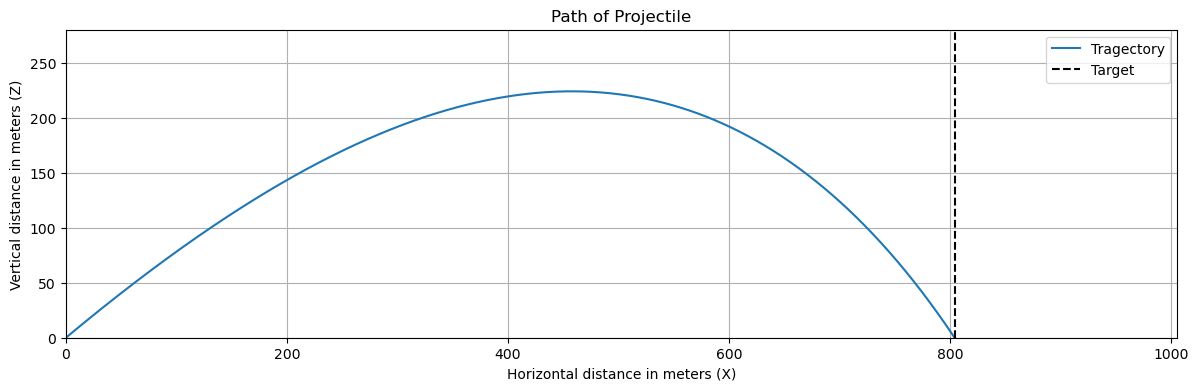

In [6]:
def RK4(y,system:callable,h,t):
    k1=system(t,y)
    k2=system(t+h/2,y+(k1/2)*h)
    k3=system(t+h/2,y+(k2/2)*h)
    k4=system(t+h,y+(k3)*h)  
    
        
        # Update y value using the weighted average of the slopes
    y=y+(1/6)*(k1+2*k2+2*k3+k4)*h
    return y

def Euler(t_0:float,t_f:float,h:float,S_initial:float,dSdt:callable)-> tuple [np.ndarray:'S values',np.ndarray]:
    ''' Runs Euler method
    
    Args:
        t_0: the initial time
        t_f: the finial time
        h: the step length between the initial and finial time
        S_initial: the initial condition
        dSdt: the ODE for S
        
    Returns:
        tuple of 2 arrays
        (t_span,S)
        
    '''
    t_span=np.arange(t_0,t_f+h,h) # creates span
    
    S=np.zeros((len(t_span),4)) # Creates array for outputs
    S[0]=S_initial #Sets intial value
    
    # Runs euler aproximation
    for i in range(len(t_span)-1):
        S[i+1]=S[i]+h*dSdt(t_span[i],S[i])
    
    # Returns t_span and the outputs
    return t_span,S

def system(t,state):
    x,z,v_x,v_z=state
    g=9.8 #m/s^2
    c=1e-3 #m^-1
    dx=v_x
    dz=v_z
    v=np.sqrt(v_x**2+v_z**2)
    dv_x=-c*v_x*v
    dv_z=-g-c*v_z*v
    
    return np.array([dx,dz,dv_x,dv_z])


def z_zero(theta,v,t_initial,target,t_step):
    vx=v*np.cos(np.deg2rad(theta))
    vz=v*np.sin(np.deg2rad(theta))
    sol=np.array([0,0,vx,vz])
    t=t_initial
    z=1
    
    while z>0.0:
        sol=RK4(sol,system,t_step,t)
        t+=t_step
        z=sol[1]
    if sol[0]<target:
      return None
    return t



def find(theta,v_range,target,t_initial,t_step):
    for v in v_range:
        t_f=z_zero(theta,v,t_initial,target,t_step)
        if t_f!=None:
            return [theta,v,t_f]
    return None



def solve_v0(target,t_initial,t_step,theta,v_min,v_max,v_step= 1000.0):
    
    v_range=np.arange(v_min,v_max+v_step,v_step)
    sol=find(theta,v_range,target,t_initial,t_step)
    if sol==None:
        # print(f'None For {theta}')
        return None,None,None
    if v_step>.001:
        return solve_v0(target,t_initial,t_step,theta,sol[1]-v_step,sol[1],v_step/10)
    else:
         return sol


def Solve_Best(target_x, angles=np.arange(0, 80 , 5)):
    best = None

    for theta in angles:
        _,v0,tf = solve_v0(target_x,0,0.01,theta,0,500)
        if v0 != None and (best is None or v0 < best[1]):
            best = (theta, v0,tf)

    return best

target=804.5
best=Solve_Best(target)
print(f"Best Tested Values:\nAngle:{best[0]:5.2f}\nVelocity:{best[1]:6.2f}")

v0=best[1] #m/s
theta0=best[0]
t_initial=0
t_step=0.0001

y0=np.array([0,0,v0*np.cos(np.deg2rad(theta0)),v0*np.sin(np.deg2rad(theta0))])

t_c,v=Euler(t_initial,best[2],t_step,y0,system)

initial=v[0]
finial=v[len(v)-1]
print(f'Initail:\nX:{initial[0]:6.2f} m | Z:{initial[1]:6.2f} m | V:{np.sqrt(initial[2]**2+initial[3]**2):6.2f} m/s\n')
print(f'Finial:\nX:{finial[0]:6.2f} m | Z:{finial[1]:6.2f} m | V:{np.sqrt(finial[2]**2+finial[3]**2):6.2f} m/s')

v=v.T
figscale=4
plt.figure(figsize=(figscale*v[0].max()/v[1].max(),figscale))
plt.plot(v[0],v[1],label='Tragectory')
plt.xlabel("Horizontal distance in meters (X)")
plt.ylabel("Vertical distance in meters (Z)")
plt.title("Path of Projectile")
plt.vlines(target,0,v[1].max()*1.25,linestyles='--',colors='black',label='Target')
plt.ylim((0,v[1].max()*1.25))
plt.xlim((0,v[0].max()*1.25))
plt.grid()
plt.legend()
plt.show()

## B
___

If we were to decrease the value of `c`, the behavior of the projectile becomes more and more parabolic. on the contrary if we increase the value of `c` the angle becomes more horizontal and the initial speed increases to reach the same point, resulting in more and more "*unreachable*" distances.

## C
---

### Head winds


===== Part C Results (With 10 m/s Headwind) =====
Solved v0 (m/s): 142.44543027638187
Solved θ0 (degrees): 32.85058103015075


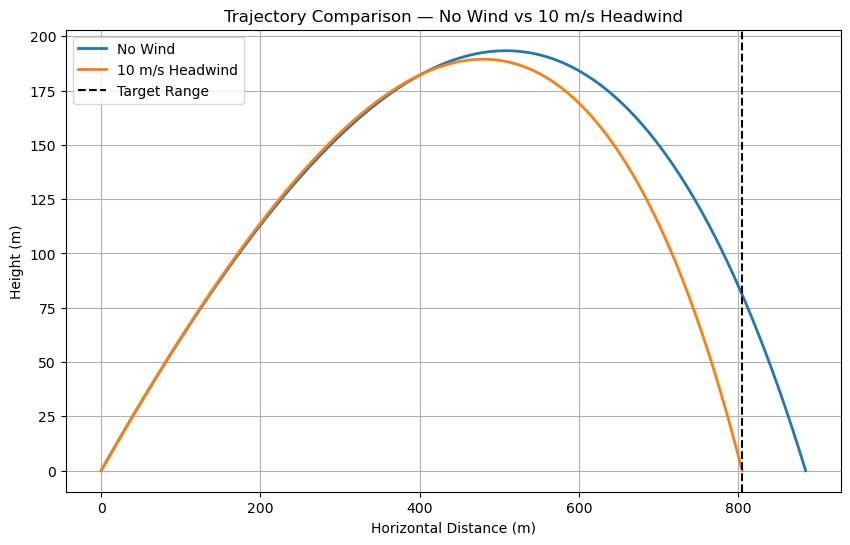

In [7]:
# Part C)
# Considering a head wind of 10 m/s

# Euler Method + Drag + Bisection + Comparison Plot

import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81
c = 1e-3
wind = -10.0     # 10 m/s headwind (negative = pushing against projectile)

# Euler Vector Method
def euler_vec(F, y0, t0, tmax, dt):
    N = int((tmax - t0) / dt) + 1
    t = np.linspace(t0, tmax, N)
    y = np.zeros((N, len(y0)))
    y[0] = y0
    
    for i in range(N - 1):
        y[i+1] = y[i] + dt * F(t[i], y[i])
        
        # stop when projectile hits ground
        if y[i+1,1] < 0:
            return t[:i+2], y[:i+2]
    return t, y


# ODE WITHOUT wind (for comparison)
def projectile_ode_no_wind(t, y):
    x, z, vx, vz = y
    v = np.sqrt(vx**2 + vz**2)
    dvx = -c * vx * v
    dvz = -g - c * vz * v
    return np.array([vx, vz, dvx, dvz])


# ODE WITH 10 m/s Headwind
def projectile_ode_wind(t, y):
    x, z, vx, vz = y
    
    # relative velocity including wind
    vrel_x = vx - wind
    vrel_z = vz
    vrel = np.sqrt(vrel_x**2 + vrel_z**2)

    dvx = -c * vrel_x * vrel
    dvz = -g - c * vrel_z * vrel
    return np.array([vx, vz, dvx, dvz])


# Range computation helper
def compute_range(v0, theta_deg, with_wind=True):
    theta = np.radians(theta_deg)
    vx0 = v0 * np.cos(theta)
    vz0 = v0 * np.sin(theta)

    y0 = np.array([0, 0, vx0, vz0])
    ode = projectile_ode_wind if with_wind else projectile_ode_no_wind

    t, Y = euler_vec(ode, y0, 0, 60, 0.001)
    return Y[-1,0]


# Bisection Method
def bisection(func, a, b, tol=1e-3, max_iter=100):
    fa = func(a)
    fb = func(b)

    if fa * fb > 0:
        raise ValueError("Bisection error: interval does not bracket root")

    for _ in range(max_iter):
        m = 0.5 * (a + b)
        fm = func(m)

        if abs(fm) < tol:
            return m
        
        if fa * fm < 0:
            b, fb = m, fm
        else:
            a, fa = m, fm

    return 0.5 * (a + b)


# PART C — Solve for v0 and theta with 10 m/s headwind
target_range = 0.5 * 1609.34   # 0.5 miles → meters


fixed_theta = 40

def f_v0(v0):
    return compute_range(v0, fixed_theta, with_wind=True) - target_range


# bracket v0
v_vals = np.linspace(10, 500, 200)
for i in range(len(v_vals)-1):
    if f_v0(v_vals[i]) * f_v0(v_vals[i+1]) < 0:
        v0_a, v0_b = v_vals[i], v_vals[i+1]
        break

v0_solution = bisection(f_v0, v0_a, v0_b)
print("\n===== Part C Results (With 10 m/s Headwind) =====")
print("Solved v0 (m/s):", v0_solution)


# Solve θ0 using the solved v0
def f_theta(theta):
    return compute_range(v0_solution, theta, with_wind=True) - target_range

theta_vals = np.linspace(10, 80, 200)
for i in range(len(theta_vals)-1):
    if f_theta(theta_vals[i]) * f_theta(theta_vals[i+1]) < 0:
        th_a, th_b = theta_vals[i], theta_vals[i+1]
        break

theta_solution = bisection(f_theta, th_a, th_b)
print("Solved θ0 (degrees):", theta_solution)


# Compute trajectories for comparison
def trajectory(v0, theta_deg, with_wind=True):
    theta = np.radians(theta_deg)
    vx0 = v0*np.cos(theta)
    vz0 = v0*np.sin(theta)
    y0 = np.array([0,0,vx0,vz0])
    return euler_vec(projectile_ode_wind if with_wind else projectile_ode_no_wind,
                     y0, 0, 60, 0.001)

# With wind
t_w, Y_w = trajectory(v0_solution, theta_solution, with_wind=True)

# Without wind (same v0, same θ)
t_nw, Y_nw = trajectory(v0_solution, theta_solution, with_wind=False)


# Comparison Plot
x_w, z_w = Y_w[:,0], Y_w[:,1]
x_nw, z_nw = Y_nw[:,0], Y_nw[:,1]

plt.figure(figsize=(10,6))
plt.plot(x_nw, z_nw, label="No Wind", linewidth=2)
plt.plot(x_w, z_w, label="10 m/s Headwind", linewidth=2)
plt.axvline(target_range, color='k', linestyle='--', label="Target Range")

plt.title("Trajectory Comparison — No Wind vs 10 m/s Headwind")
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Height (m)")
plt.grid(True)
plt.legend()
plt.show()


### Starting Altitude

Best Tested Values:
Angle:20.00
Velocity: 82.04
Initail:
X:  0.00 m | Z:804.50 m | V: 82.04 m/s

Finial:
X:804.51 m | Z: -0.47 m | V: 89.75 m/s


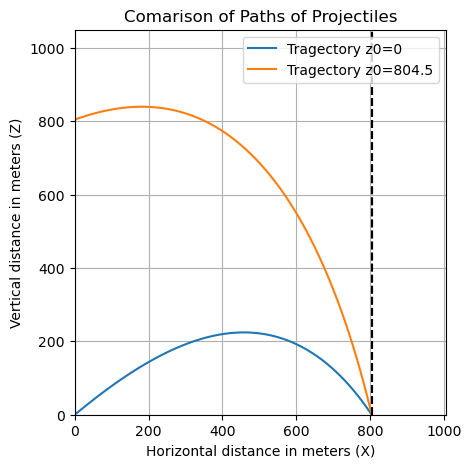

In [8]:

def z_zero(z0,theta,v,t_initial,target,t_step):
    vx=v*np.cos(np.deg2rad(theta))
    vz=v*np.sin(np.deg2rad(theta))
    sol=np.array([0,z0,vx,vz])
    t=t_initial
    z=1
    
    while z>0.0:
        sol=RK4(sol,system,t_step,t)
        t+=t_step
        z=sol[1]
    if sol[0]<target:
      return None
    return t



def find(z0,theta,v_range,target,t_initial,t_step):
    for v in v_range:
        t_f=z_zero(z0,theta,v,t_initial,target,t_step)
        if t_f!=None:
            return [theta,v,t_f]
    return None



def solve_v0(target,t_initial,t_step,theta,v_min,v_max,z0=0,v_step= 1000.0):
    
    v_range=np.arange(v_min,v_max+v_step,v_step)
    sol=find(z0,theta,v_range,target,t_initial,t_step)
    if sol==None:
        # print(f'None For {theta}')
        return None,None,None
    if v_step>.001:
        return solve_v0(target,t_initial,t_step,theta,sol[1]-v_step,sol[1],z0,v_step/10)
    else:
         return sol


def Solve_Best(target_x,z0=0, angles=np.arange(0, 80 , 5)):
    best = None

    for theta in angles:
        _,v0,tf = solve_v0(target_x,0,0.01,theta,0,500,z0)
        if v0 != None and (best is None or v0 < best[1]):
            best = (theta, v0,tf)

    return best

target_alt=804.5
z0=804.5
best_alt=Solve_Best(target_alt,z0)
print(f"Best Tested Values:\nAngle:{best_alt[0]:5.2f}\nVelocity:{best_alt[1]:6.2f}")


# Validation
v0=best_alt[1] #m/s
theta0=best_alt[0]
t_initial=0
t_step=0.0001

y0=np.array([0,z0,v0*np.cos(np.deg2rad(theta0)),v0*np.sin(np.deg2rad(theta0))])

t_c,v_alt=Euler(t_initial,best_alt[2],t_step,y0,system)

initial=v_alt[0]
finial=v_alt[len(v_alt)-1]
print(f'Initail:\nX:{initial[0]:6.2f} m | Z:{initial[1]:6.2f} m | V:{np.sqrt(initial[2]**2+initial[3]**2):6.2f} m/s\n')
print(f'Finial:\nX:{finial[0]:6.2f} m | Z:{finial[1]:6.2f} m | V:{np.sqrt(finial[2]**2+finial[3]**2):6.2f} m/s')

v_alt=v_alt.T
figscale=5
plt.figure(figsize=(figscale*max(v_alt[0].max(),v[0].max())/max(v_alt[1].max(),v[1].max()),figscale))
plt.title("Comarison of Paths of Projectiles")
plt.plot(v[0],v[1],label='Tragectory z0=0')
plt.plot(v_alt[0],v_alt[1],label=f'Tragectory z0={z0}')
plt.xlabel("Horizontal distance in meters (X)")
plt.ylabel("Vertical distance in meters (Z)")
plt.legend()
plt.ylim((0,max(v_alt[1].max(),v[1].max())*1.25))
plt.xlim((0,max(v_alt[0].max(),v[0].max())*1.25))
plt.vlines(target_alt,0,max(v_alt[1].max(),v[1].max())*1.25,linestyles='--',colors='black',label='Target')
plt.vlines(target,0,max(v_alt[1].max(),v[1].max())*1.25,linestyles='--',colors='black',label='Target')

plt.grid()
plt.show()